## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [19]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i , n_units in enumerate(num_neurons):
        if  i == 0:
            x = keras.layers.Dense(units = n_units,
                                   activation = "relu",
                                   name = "hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units = n_units,
                                   activation = "relu",
                                   name = "hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units = output_units, activation = "softmax",name = "output")(x)
    model = keras.models.Model(input=[input_layer],output = [out])
    return model

In [20]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [21]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5,0.9]
redice_lr_patient = [5,10]

In [22]:
import itertools
aa  = itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)
for elem in aa:
    print(elem)

(<keras.optimizers.SGD object at 0x000002175DACD198>, 0.5, 5)
(<keras.optimizers.SGD object at 0x000002175DACD198>, 0.5, 10)
(<keras.optimizers.SGD object at 0x000002175DACD198>, 0.9, 5)
(<keras.optimizers.SGD object at 0x000002175DACD198>, 0.9, 10)
(<keras.optimizers.Adam object at 0x000002175DACD128>, 0.5, 5)
(<keras.optimizers.Adam object at 0x000002175DACD128>, 0.5, 10)
(<keras.optimizers.Adam object at 0x000002175DACD128>, 0.9, 5)
(<keras.optimizers.Adam object at 0x000002175DACD128>, 0.9, 10)
(<keras.optimizers.RMSprop object at 0x000002175DACD278>, 0.5, 5)
(<keras.optimizers.RMSprop object at 0x000002175DACD278>, 0.5, 10)
(<keras.optimizers.RMSprop object at 0x000002175DACD278>, 0.9, 5)
(<keras.optimizers.RMSprop object at 0x000002175DACD278>, 0.9, 10)


In [23]:
list(enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)))

[(0, (<keras.optimizers.SGD at 0x2175dacd198>, 0.5, 5)),
 (1, (<keras.optimizers.SGD at 0x2175dacd198>, 0.5, 10)),
 (2, (<keras.optimizers.SGD at 0x2175dacd198>, 0.9, 5)),
 (3, (<keras.optimizers.SGD at 0x2175dacd198>, 0.9, 10)),
 (4, (<keras.optimizers.Adam at 0x2175dacd128>, 0.5, 5)),
 (5, (<keras.optimizers.Adam at 0x2175dacd128>, 0.5, 10)),
 (6, (<keras.optimizers.Adam at 0x2175dacd128>, 0.9, 5)),
 (7, (<keras.optimizers.Adam at 0x2175dacd128>, 0.9, 10)),
 (8, (<keras.optimizers.RMSprop at 0x2175dacd278>, 0.5, 5)),
 (9, (<keras.optimizers.RMSprop at 0x2175dacd278>, 0.5, 10)),
 (10, (<keras.optimizers.RMSprop at 0x2175dacd278>, 0.9, 5)),
 (11, (<keras.optimizers.RMSprop at 0x2175dacd278>, 0.9, 10))]

In [24]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 790,282
Trainable params: 789,770
Non-trainable params: 512
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 56us/step - loss: 2.1135 - acc: 0.2784 - val_loss: 1.9973 - val_acc: 0.3209
Epoch 2/10
50000/50000 [==============================] - 2s 46us/step - loss: 1.7770 - acc: 0.3791 - val_loss: 1.7917 - val_acc: 0.3830
Epoch 3/10
50000/50000 [==============================] - 2s 47us/step - loss: 1.6985 - acc: 0.4068 - val_loss: 1.6953 - val_acc: 0.4038
Epoch 4/10
50000/50000 [==============================] - 2s 46us/step - loss: 1.6544 - acc: 0.4252 - val_loss: 1.6620 - val_acc: 0.4215
Epoch 5/10
50000/50000 [==============================] - 2s 46us/step - loss: 1.6209 - acc: 0.4347 - val_loss: 1.6327 - val_acc: 0.4349
Epoch 6/10
50000/50000 [==============================] - 2s 46us/step - loss: 1.5928 - acc: 0.4440 - val_loss: 1.6203 - val_acc: 0.4399
Epoch 7/10
50000/50000 [==============================] - 2s 46us/step - loss: 1.5695 - acc: 0.4539 - val_loss: 1.5958 - val_acc

50000/50000 [==============================] - 3s 52us/step - loss: 1.5274 - acc: 0.4729 - val_loss: 1.5737 - val_acc: 0.4497
Epoch 10/10
50000/50000 [==============================] - 3s 54us/step - loss: 1.5100 - acc: 0.4798 - val_loss: 1.5804 - val_acc: 0.4431
Numbers of exp: 4, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 790,282
Trainable params: 789,770
Non-trainable params: 512
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 69us/step - loss: 1.8566 - acc: 0.3582 - val_loss: 1.7766 - val_acc: 0.3783
Epoch 2/10
50000/50000 [==============================] - 3s 53us/step - loss: 1.6750 - acc: 0.4184 - val_loss: 1.7740 - val_acc: 0.3629A: 1s - loss: 1.6
Epoch 3/10
50000/50000 [==============================] - 3s 53us/step - loss: 1.5997 - acc: 0.4454 - val_loss: 1.7337 - val_acc: 0.3909
Epoch 4/10
50000/50000 [==============================] - 3s 52us/step - loss: 1.5544 - acc: 0.4598 - val_loss: 1.8223 - val_acc: 0.3469
Epoch 5/10
50000/50000 [==============================] - 3s 53us/step - loss: 1.5121 - acc: 0.4749 - val_loss: 1.6542 - val_acc: 0.4108
Epoch 6/10
50000/50000 [==============================] - 3s 53us/step - loss: 1.4849 - acc: 0.4833 - val_loss: 1.6544 - val_acc: 0.4084
Epoch 7/10
50000/50000 [==============================] - 3s 53us/step - loss: 1.4588 - acc: 0.4927 - val_loss:

Epoch 9/10
50000/50000 [==============================] - 3s 56us/step - loss: 1.4765 - acc: 0.4856 - val_loss: 1.7469 - val_acc: 0.3814
Epoch 10/10
50000/50000 [==============================] - 3s 57us/step - loss: 1.4566 - acc: 0.4930 - val_loss: 1.7192 - val_acc: 0.3827
Numbers of exp: 11, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_38 (Batc (None, 256)               1024      
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 790,282
Trainable params: 789,770
Non-trainable params: 5

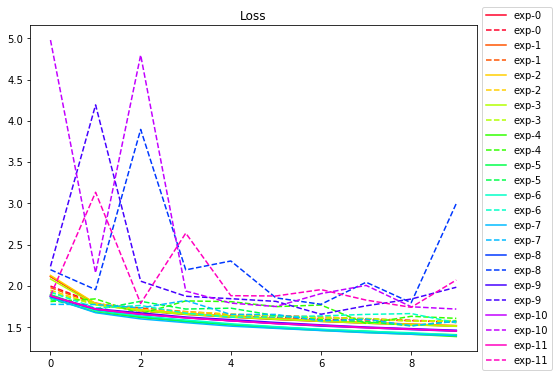

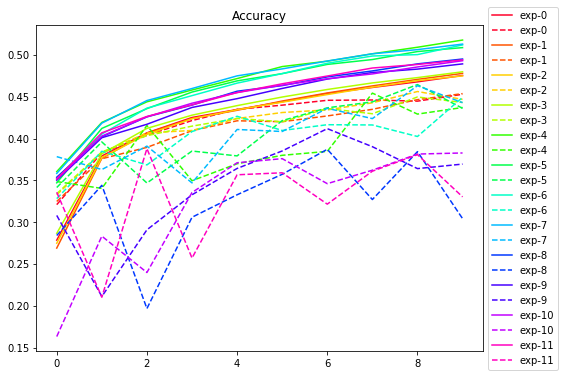

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()